In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy as sp
import re
import os, sys
import json

%matplotlib inline

In [39]:
data_directory = './dataset/deezer_clean_data/'
graph_directory = './graphs/'
country = 'RO'
csv_name = country + '_edges.csv'
genre_json = country + '_genres.json'
top_5000_subset_directory = data_directory + 'top_5000_edges_subset/'

if not os.path.exists(graph_directory):
    os.makedirs(graph_directory)
if not os.path.exists(top_5000_subset_directory):
    os.makedirs(top_5000_subset_directory)

## Read and sample friendship data

In [50]:
df = pd.read_csv(data_directory + csv_name)
df.head(10)

,node_1,node_2
0,0,37825
1,0,17224
2,0,6356
3,1,18053
4,1,31265
5,1,28257
6,1,41010
7,1,19010
8,1,10785
9,1,41676


In [51]:
# Get the nodes with top degrees
df['degree'] = df.groupby('node_1')['node_1'].transform('count')
degree_sorted_df = df.sort_values('degree', ascending=False)
degree_sorted_df.head(10)

,node_1,node_2,degree
12026,2003,18838,109
11983,2003,5828,109
12044,2003,13476,109
12043,2003,4678,109
12042,2003,15722,109
12041,2003,21864,109
12040,2003,10768,109
12039,2003,12185,109
12038,2003,19017,109
12037,2003,39073,109


In [76]:
# subset_df = degree_sorted_df.sample(5000).sort_values('node_1')
# Get 5000 edges of the top degree nodes
subset_df = degree_sorted_df.head(5000)
subset_df.head(10)

,node_1,node_2,degree
12026,2003,18838,109
11983,2003,5828,109
12044,2003,13476,109
12043,2003,4678,109
12042,2003,15722,109
12041,2003,21864,109
12040,2003,10768,109
12039,2003,12185,109
12038,2003,19017,109
12037,2003,39073,109


## Degree distribution

In [77]:
#Degree distributions
def plot_degree_distributions(graphs):
    for graph in graphs:
        degree_sequence=sorted(dict(nx.degree(graph)).values(),reverse=True) 
        dmax=max(degree_sequence)
        print('Degree max for {}: {}'.format(graph, dmax))
        
        plt.figure()
        h,bins,patches = plt.hist(degree_sequence,bins=range(0,dmax))
        plt.title("Degree distribution for {}".format(graph.name))
        plt.xlabel("degree")
        plt.ylabel("number of nodes")

## Create Graphs

In [82]:
G = nx.Graph()
G.add_nodes_from(subset_df['node_1'])
G.add_nodes_from(subset_df['node_2'])
G.add_edges_from(subset_df[['node_1','node_2']].values)
G.name = 'Graph of ' + country

nx.write_gml(G, graph_directory + country + '_graph.gml')
degree_sequence = dict(nx.degree(G)).values()
print("Average degree of subset:", sum(degree_sequence)/len(degree_sequence))
print("Average degree of subset users in original dataset:", sum(subset_df['degree'])/len(subset_df['degree']))

Average degree of subset: 2.4437927663734116
Average degree of subset users in original dataset: 33.3756


Degree max for Graph of RO: 110


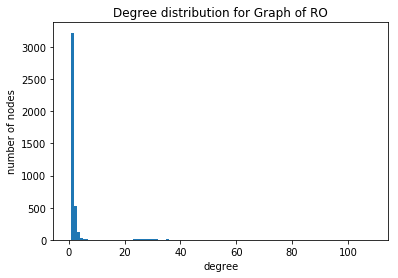

In [62]:
plot_degree_distributions([G])

In [47]:
degree_sequence=sorted(dict(nx.degree(G)).values(),reverse=True) 
len(degree_sequence)

4092

### Create csv from top 5000

In [9]:
header = ["node_1", "node_2"]
subset_df.to_csv(top_5000_subset_directory + csv_name, columns = header)

### Create genre dict from top 5000

In [84]:
with open(os.path.join(data_directory, genre_json)) as infile:
    genre_dict = json.load(infile)
    
unique_nodes = set(subset_df['node_1'].values.tolist() + subset_df['node_2'].values.tolist())
subset_genre_dict = { str(node): genre_dict[str(node)] for node in unique_nodes }

with open(top_5000_subset_directory + genre_json, 'w') as outfile:
    json.dump(subset_genre_dict, outfile)